In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap

C:\Users\Anish Kumar Verma\PycharmProjects\HOML\.venv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df=pd.read_csv('../Data/heart_data_preprocessed.csv')

In [5]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289.0,0,172.0,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180.0,0,156.0,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283.0,0,98.0,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214.0,0,108.0,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195.0,0,122.0,0.0,0,1,0,1,0,1,0,0,0,1


In [6]:
X = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [7]:
all_cols=list(X.columns)
all_cols

['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'Sex_M',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ChestPainType_TA',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ExerciseAngina_Y',
 'ST_Slope_Flat',
 'ST_Slope_Up']

In [8]:
numeric_cols = [
    'Age',
    'RestingBP',
    'Cholesterol',
    'MaxHR',
    'Oldpeak'
]

binary_cols = [
    'FastingBS',
    'Sex_M',
    'ChestPainType_ATA',
    'ChestPainType_NAP',
    'ChestPainType_TA',
    'RestingECG_Normal',
    'RestingECG_ST',
    'ExerciseAngina_Y',
    'ST_Slope_Flat',
    'ST_Slope_Up'
]

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numeric_cols),
        ("bin", "passthrough", binary_cols)
    ]
)


In [10]:
param_grid_stage1 = {
    "model__max_depth": [3, 4, 5, 6],

    "model__min_child_weight": [10, 15],

    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__n_estimators": [200, 300,400,600,800]
}

In [11]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    ))
])

In [12]:
from sklearn.model_selection import GridSearchCV

grid1 = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_stage1,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid1.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['FastingBS',
                                                                          'Sex_M',
                                                                          'ChestPainType_ATA',
                                                                          'ChestPainType_NAP',
                                                                          'ChestPainType_TA',
                                                                          'RestingECG_Normal',
                                                                          'RestingECG_ST',
                                                                          'ExerciseAngina_Y',
                                                                          'ST_Slope_Flat',
                                                                          'ST_Slope_Up'...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 4, 5, 6],
                         'model__min_child_weight': [10, 15],
                         'model__n_estimators': [200, 300, 400, 600, 800]},
             scoring='recall', verbose=2)

In [13]:
print("Best Recall:", grid1.best_score_)
print("Best params:")
for k, v in grid1.best_params_.items():
    print(f"  {k}: {v}")


Best Recall: 0.8803258145363408
Best params:
  model__learning_rate: 0.01
  model__max_depth: 3
  model__min_child_weight: 10
  model__n_estimators: 400


In [14]:
best_structure_params = grid1.best_params_
pipeline.set_params(**best_structure_params)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('bin', 'passthrough',
                                                  ['FastingBS', 'Sex_M',
                                                   'ChestPainType_ATA',
                                                   'ChestPainType_NAP',
                                                   'ChestPainType_TA',
                                                   'RestingECG_Normal',
                                                   'RestingECG_ST',
                                                   'ExerciseAngina_Y',
                                                   'ST_Slope_Flat',
                                                   'ST_Slope_Up'])])),
                ('model',
                 XGBClassifier...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [15]:
final_model=grid1.best_estimator_


In [16]:
final_model.named_steps["model"].get_params()


{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': 10,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 400,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [38]:
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8533333333333334


In [53]:
y_prob = final_model.predict_proba(X_test)[:, 1]
threshold = 0.35
y_pred = (y_prob >= threshold).astype(int)

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.9278846153846154


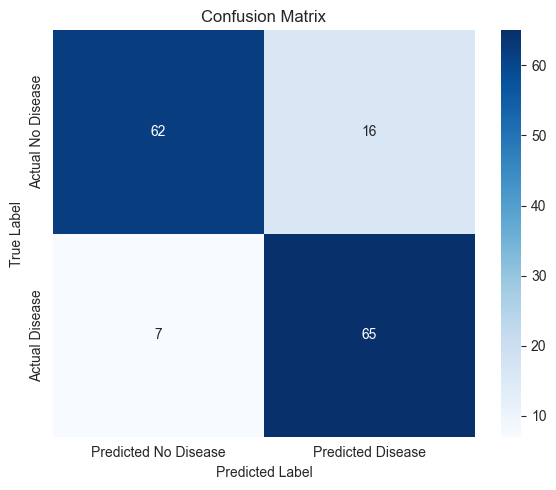

In [54]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted No Disease", "Predicted Disease"],
    yticklabels=["Actual No Disease", "Actual Disease"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [55]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred, pos_label=1)
print("Recall:", recall)

Recall: 0.9027777777777778


In [56]:
xgb_model = final_model.named_steps["model"]


In [57]:
all_feature_names = df.drop(columns=["HeartDisease"]).columns.tolist()


In [58]:

importance = xgb_model.get_booster().get_score(importance_type="gain")

importance_df = (
    pd.DataFrame.from_dict(importance, orient="index", columns=["gain"])
    .reset_index()
    .rename(columns={"index": "feature"})
)


In [59]:
importance_df["feature_index"] = importance_df["feature"].str.replace("f", "").astype(int)
importance_df["feature_name"] = importance_df["feature_index"].apply(
    lambda i: all_feature_names[i]
)

importance_df = importance_df.sort_values("gain", ascending=False)
importance_df


,feature,gain,feature_index,feature_name
11,f14,58.898129,14,ST_Slope_Up
10,f13,18.840746,13,ST_Slope_Flat
9,f12,15.796367,12,ExerciseAngina_Y
5,f6,7.841380,6,Sex_M
7,f8,7.175711,8,ChestPainType_NAP
6,f7,6.222499,7,ChestPainType_ATA
4,f4,5.173337,4,MaxHR
0,f0,4.063561,0,Age
3,f3,3.395284,3,FastingBS
8,f10,3.340521,10,RestingECG_Normal


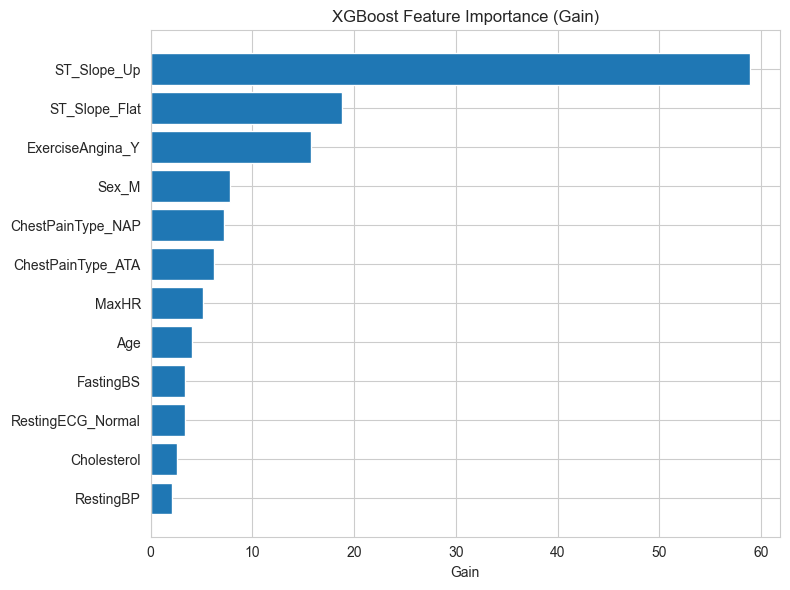

In [26]:
plt.figure(figsize=(8, 6))
plt.barh(
    importance_df["feature_name"],
    importance_df["gain"]
)
plt.gca().invert_yaxis()
plt.xlabel("Gain")
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()


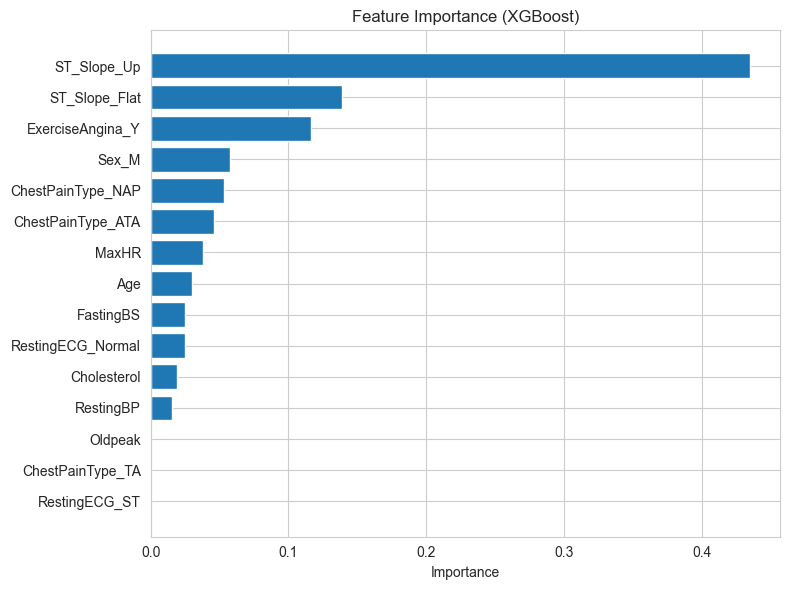

In [27]:
xgb_model = final_model.named_steps["model"]

importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(
    importance_df["feature"],
    importance_df["importance"]
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


In [29]:
import joblib

joblib.dump(grid1.best_estimator_, "../models/heart_attack_detection.pkl")

['../models/heart_attack_detection.pkl']